# Define Canonical Helix regions
This notebook is designed to identify regions on the \$ \kappa \tau w \$ space which geometrical helices tends to be found.
Different kinds of SSE are, in essence, different kinds of geometrical helices.
By definition, different SSE should be common and occupy different regions on the \$ \kappa \tau w \$ space.

Starting from fragments found on a clustered PDB dataset:

1. first we select only geometrical helices by filtering fragments by \$\sigma_{\tau}, \sigma_{\kappa}\$ and size
2. Check the distribution of SSE according to DSSP
3. Split the dataset into two regions (via \$\langle w \rangle\$)
4. Cluster the helices by density (via HDBSCAN)
5. Saving the clusters / core clusters found so it can be used for soft clustering




## Import
First step is to import all the libraries used. Be sure all those libraries are available on the environment.


In [1]:
import pandas as pd
import pickle as pck
import matplotlib.pyplot as plt
import seaborn as sns
import ssaxgeo.MathToolBox as MathToolBox
import hdbscan
import numpy as np

## Set input variables

all moving parts of this analysis will be set here:

In [2]:
# --- set Paths ---
# path to fragments dataframe
#grp_frag_df_flpath = "/home/antonio/Projects/HlxCnt/BC30/grp_frag_df_clust-30.p"
#grp_frag_df_flpath = "/home/antonio/Projects/HlxCnt/BC90/grp_frag_df_clust-90.p"
grp_frag_df_flpath = "/home/antonio/Projects/HlxCnt/Paper/pdb_rerun/grp_frag_df_clust-30.csv"

# set directory to store outputs
save_dir = "./"

# --- set filtering fragments params ----
# set minimum size of helix to be considered
min_size = 4

# --- set clustering params ---
# minimum cluster size to be considered
min_cluster_size = 100

# set minimum membership probability for a point
# be considered as part of the core of the cluster 
Pc_LIM = 0.35

## NOTES
# Export dataframe as csv on previous step

## Functions

All the functions will be defined here:


In [39]:
def count_occurrences_above_threshold(arr, threshold_percentage=75):
    """
    Count elements of an array and return the one which represents at least
    a given percentage of the total elements.
    """
    
    unique_elements, counts = np.unique(arr, return_counts=True)
    
    try:
        total_elements = len(arr)
    except(TypeError):
        print("t error")
        return None
    
    # Calculate the occurrence percentages
    percentages = (counts / total_elements) * 100

    # Find elements with occurrence higher than the threshold
    result = unique_elements[percentages > threshold_percentage]

    if len(result) > 0:
        assert(len(result) == 1)
        return result.tolist()[0]
    else:
        return None

count_occurrences_above_threshold(np.array(["H","I","I","I","I","I"]), threshold_percentage=51)

'I'

### clustering functions:

In [4]:
def cluster_grp_frags(frag_df, max_d=1.0, show_plot=False,
    cols = ['c_mean', 'w_mean', 't_mean'], method='kmeans', **cls_kwargs):
    '''Recluster group fragment dataframe.'''
    #TODO add sanity check
    VALID_METHODS = ['kmeans', 'hdbscan', 'hierarc']
    assert(method in VALID_METHODS), '{} not supported'.format(method)

    # get data to cluster
    #vld_frag_df = self.grp_frag_df[cols]
    vld_frag_df = frag_df[cols]

    if method == 'hierarc':
            # TODO improve kwargs handling, instead of using a default value
            #      maybe will be better to let the user have more control
            max_d = cls_kwargs.get('max_d', 1.0)
            # Calculate linkage matrix
            Z = MathToolBox.get_linkage_mtx_of(vld_frag_df)

            # get clusters assignment array
            clusters = fcluster(Z, max_d, criterion='distance')

            # generate plots
            if show_plot is True:
                MathToolBox.fancy_dendrogram(Z,
                    truncate_mode='lastp', p=12,# show only the last p merged clusters
                    leaf_rotation=90.,
                    leaf_font_size=12.,
                    show_contracted=True,
                    annotate_above=0.1,  # useful in small plots so annotations don't overlap
                    max_d=max_d)

    if method == 'kmeans':
            # clustering specific arguments
            err_msg = 'n_clusters = <int> must be provided for kmeans'
            assert('n_clusters' in cls_kwargs), err_msg

            n_clusters = cls_kwargs['n_clusters']
            random_state = cls_kwargs.get('random_state', 0)
            n_jobs= cls_kwargs.get('n_jobs', 1)

            # do the clustering
            clusters = MathToolBox.run_kmeans_at(vld_frag_df,
                        n_clusters, random_state=random_state, n_jobs=n_jobs)

    if method == 'hdbscan':
            # got clustering arguments
            min_cluster_size = cls_kwargs['min_cluster_size']
            do_soft = cls_kwargs.get('do_soft', True)
            use_distMTX = cls_kwargs.get('use_distMTX', False)
            allow_single_cluster=cls_kwargs.get('allow_single_cluster', True)

            # do the clustering
            clusterer = MathToolBox.do_hdbscan_at(vld_frag_df,
                            min_cluster_size,do_soft=do_soft,
                            use_distMTX=use_distMTX,
                            allow_single_cluster=allow_single_cluster)
            clusters = clusterer.labels_

    ### NOTE ###########################################################
    ## for the future, add clusters probabilities for soft clustering
    ####################################################################

    # add clustering results column to group fragments dataframe
    cluster_col = pd.DataFrame(clusters, columns=['grp_frag_clusters'],
                               index=vld_frag_df.index)
    final_df = pd.concat([frag_df, cluster_col], axis=1)
    if method == 'hdbscan' and do_soft == True:
            return final_df, clusterer
    else:
            return final_df


In [5]:
def get_core_labels(df, Pc_LIM):
    '''
    Check if a residue belongs to the 'core' of the cluster.
    The core points in a cluster are consider each an every point which the
    membership probability is greater than a specified limit (default=0.60).
    '''
    def _check_prob(row):
        Pc_max = np.array(row['membership_vec']).max()
        if Pc_max >= Pc_LIM:
            return True
        else:
            return False

    return df.apply(_check_prob, axis=1)

In [6]:
# Determinate labels

def write_canonical_cluster_csvs(df_1_2):
    clusters = df_1_2["grp_frag_clusters"].unique()

    ssx_dssp_labels_dct = {"H": "Alpha", "G":"3(10)", "I": "Pi", "P": "PP2", "":"UNDF", "T":"Turn"}

    label_dct = {}
    for c in clusters:
        print(f"@ {c}")
        if c == -1:
            continue
        cluster_c_slice_df = df_1_2.loc[df_1_2["grp_frag_clusters"] == c]
        ss_counts_dct = cluster_c_slice_df["ss_major"].value_counts().to_dict()
    
        higher_count = 0
        label = None
        for k in ss_counts_dct.keys():
            if ss_counts_dct[k] > higher_count:
                higher_count = ss_counts_dct[k]
                dssp_label = k
        print(ss_counts_dct)
        label_dct[dssp_label] = c
        ssx_label = ssx_dssp_labels_dct[dssp_label]
        if ssx_label == "Alpha":
                alpha_df = cluster_c_slice_df.sample(n=1000, random_state=1)
                
                alpha_df.loc[:,"ssx_label"] = ssx_dssp_labels_dct[dssp_label]
                alpha_df.to_csv(f"{save_dir}/{ssx_dssp_labels_dct[dssp_label]}_can_{c}.csv")
                continue
        cluster_c_slice_df.loc[:,"ssx_label"] = ssx_dssp_labels_dct[dssp_label]
        cluster_c_slice_df.to_csv(f"{save_dir}/{ssx_dssp_labels_dct[dssp_label]}_can_{c}.csv")
    print(label_dct)

## Load input dataframe

In [34]:
#grp_frag_df_raw = pck.load(open(grp_frag_df_flpath, 'rb')).drop(columns=[0,1])
dtypes = {"label":"category", "ID":"category", "res":"category", "atom":"category",
          "res_name":"category",
          "curv":np.float32,"tor":np.float32,"wri":np.float32,"arc":np.float32,"D(Alfa)":np.float32, "D(Pi)":np.float32,
          "D(3(10))":np.float32, "D(PP2)":np.float32,
          "conf":np.int32, "aa_idx":np.int32}
grp_frag_df_raw = pd.read_csv(grp_frag_df_flpath, dtype=dtypes)#.drop(columns=[0,1])

print(f"Total number of fragments: {len(grp_frag_df_raw)}")

Total number of fragments: 390354


In [64]:
grp_frag_df_raw.columns

Index(['res_start', 'res_final', 'kind', 'size', 'label', 'pdbid', 'chain',
       'seq', 'c_mean', 't_mean', 'w_mean', 'c_std', 't_std', 'w_std', 'c_raw',
       't_raw', 'w_raw', 'cs_raw', 'ts_raw', 'ws_raw', 'cs_mean', 'ts_mean',
       'ws_mean', 'c_std_s', 't_std_s', 'ws_std', 'phi', 'psi', 'ss', 'ss_pp2',
       'ho1_en_mean', 'ho1_A_mean', 'ho1_en_std', 'ho1_A_std', 'ho1_en_median',
       'ho1_A_median', 'ho1_en_vals', 'ho1_A_vals', 'ho2_en_mean',
       'ho2_A_mean', 'ho2_en_std', 'ho2_A_std', 'ho2_en_median', 'ho2_en_vals',
       'ho2_A_vals', 'hn1_en_mean', 'hn1_A_mean', 'hn1_en_std', 'hn1_A_std',
       'hn1_en_median', 'hn1_A_median', 'hn1_en_vals', 'hn1_A_vals',
       'hn2_en_mean', 'hn2_A_mean', 'hn2_en_std', 'hn2_A_std', 'hn2_en_median',
       'hn2_A_median', 'hn2_en_vals', 'hn2_A_vals', 'ss_major'],
      dtype='object')

add a column containing the most predominant SSE element according to DSSP

In [37]:
import re

def string_to_numpy_array(s: str) -> np.ndarray:
    # Remove outer brackets
    s = s.strip("[]")
    # Split on spaces, but keep entries between quotes
    tokens = re.findall(r"'(.*?)'", s)
    return np.array(tokens)

grp_frag_df_raw["ss"] = grp_frag_df_raw["ss"].apply(string_to_numpy_array)

In [41]:
grp_frag_df_raw["ss_major"] = grp_frag_df_raw["ss"].apply(count_occurrences_above_threshold, threshold_percentage=51)
grp_frag_df_raw[["ss", "ss_major"]]

,ss,ss_major
0,"[, , E, E]",None
1,"[T, T, ]",T
2,"[E, E, E, E]",E
3,"[S, , G]",None
4,"[E, E, T]",E
...,...,...
390349,"[G, G, H]",G
390350,"[H, H, H, H, H, I]",H
390351,"[I, I, I, I, I, I]",I
390352,"[I, H, H, H, H]",H


remove res number label bugs rows 
> provisory solution, need to fix this in SSAxgeo code

In [42]:
def is_size_right(row):
    if (row["res_final"] - row["res_start"]) != row["size"]-1:
        return False
        #print(row[["pdbid", "res_start","res_final","size"]])
    else:
        return True

    
grp_frag_df_size_correct = grp_frag_df_raw[grp_frag_df_raw.apply(is_size_right, axis=1)]
print(f"Total number of fragments: {len(grp_frag_df_size_correct)}")
grp_frag_df = grp_frag_df_size_correct[~grp_frag_df_size_correct["ss"].isna()]
print(f"Total number of fragments: {len(grp_frag_df)}")

Total number of fragments: 381139
Total number of fragments: 381139


## Filtering fragments

Lets filter out all fragments which are less than the minimum size set

In [44]:
print('@ Filtering fragments...')
print(f'  :: starting with {len(grp_frag_df)} fragments')
print(f'  > removing fragments less than {min_size} residues...')
min_size_cond = grp_frag_df["size"] >= min_size
grp_fdf_1 = grp_frag_df.loc[min_size_cond]
print('  :: ', len(grp_fdf_1), ' fragments remaining')

@ Filtering fragments...
  :: starting with 381139 fragments
  > removing fragments less than 4 residues...
  ::  243731  fragments remaining


### Explore data

#### Check size to standard deviation distribution
The distribution helps to inform which standard deviation treshold should be used

(0.0, 0.1)

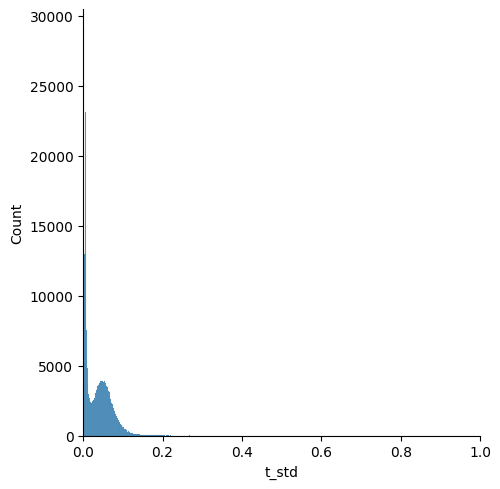

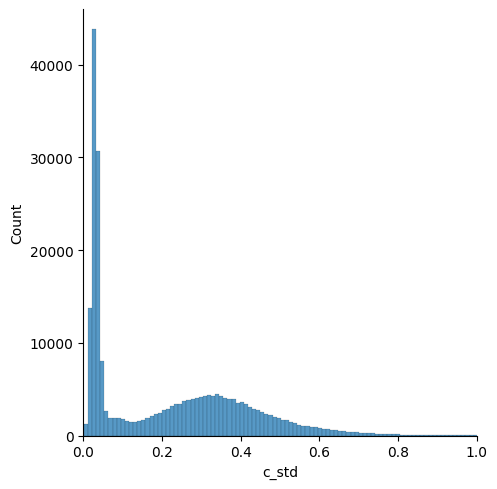

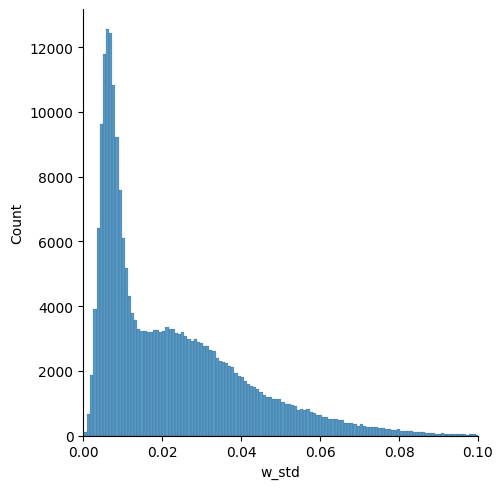

In [45]:
sns.displot(grp_fdf_1["t_std"])
plt.xlim(0,1)

sns.displot(grp_fdf_1["c_std"])
plt.xlim(0,1)

sns.displot(grp_fdf_1["w_std"])
plt.xlim(0,0.1)


(0.0, 1.0)

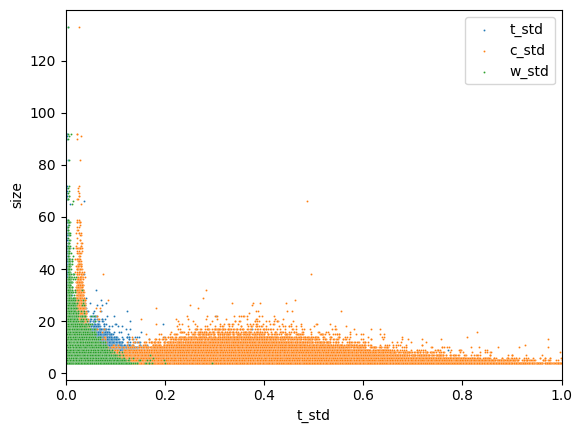

In [46]:
sns.scatterplot(data=grp_fdf_1, x="t_std", y="size", s=2, label="t_std")
sns.scatterplot(data=grp_fdf_1, x="c_std", y="size", s=2, label="c_std")
sns.scatterplot(data=grp_fdf_1, x="w_std", y="size", s=2, label="w_std")
plt.xlim(0,1)


(0.0, 0.2)

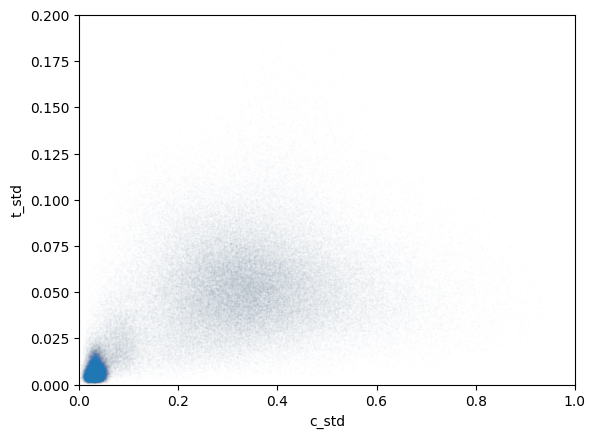

In [47]:
sns.scatterplot(data=grp_fdf_1, x="c_std", y="t_std", alpha=0.01, s=2)
#sns.scatterplot(data=grp_fdf_1, x="c_std", y="size", s=2, label="c_std")
#sns.scatterplot(data=grp_fdf_1, x="w_std", y="size", s=2, label="w_std")
plt.xlim(0,1)
plt.ylim(0, 0.2)

### FILTER BY STD

After the analysis of the distributions plot and a bit of experimentation, we set for:

- \$ \sigma_{\kappa} \leq 0.20 \$
- \$ \sigma_{\tau} \leq 0.015 \$


  > removing fragments with high standard deviations...
  ::  86487  fragments remaining
157244


(-0.2, 0.2)

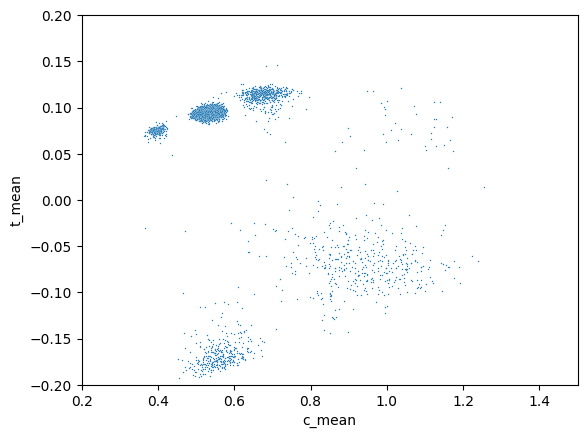

In [48]:
print('  > removing fragments with high standard deviations...')
c_std_cond = grp_fdf_1['c_std'] <= 0.2#0.55
t_std_cond = grp_fdf_1['t_std'] <= 0.01#0.015

grp_fdf_new = grp_fdf_1.loc[c_std_cond & t_std_cond]
print('  :: ', len(grp_fdf_new), ' fragments remaining')
print(len(grp_fdf_1) - len(grp_fdf_new))

#sns.scatterplot(data=grp_fdf_1, x="c_mean", y="t_mean", s=2, alpha=0.05, c="grey")
sns.scatterplot(data=grp_fdf_new, x="c_mean", y="t_mean", s=1,)#, alpha=0.05, c="red")
plt.xlim(0.2,1.5)
plt.ylim(-0.2,0.2)


<AxesSubplot: xlabel='w_mean', ylabel='t_mean'>

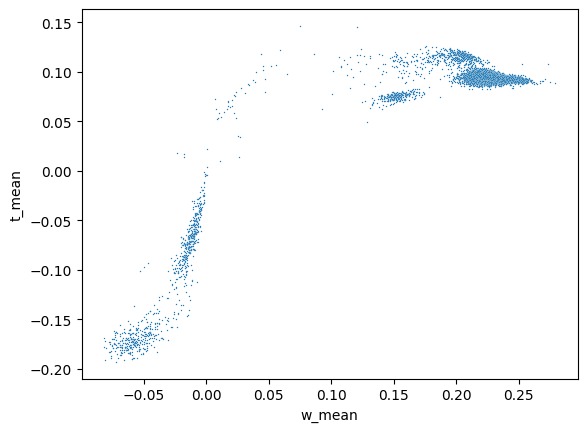

In [49]:
sns.scatterplot(data=grp_fdf_new, x="w_mean", y="t_mean", s=1,)#, alpha=0.05, c="red")

In [50]:
grp_fdf_new[(grp_fdf_new["size"] >= 4) & (grp_fdf_new["ss_major"] == "P")]

,res_start,res_final,kind,size,label,pdbid,chain,seq,c_mean,t_mean,...,hn1_A_vals,hn2_en_mean,hn2_A_mean,hn2_en_std,hn2_A_std,hn2_en_median,hn2_A_median,hn2_en_vals,hn2_A_vals,ss_major
1953,362,365,labels,4,PP2,2r7d,C,['D' 'P' 'L' 'S'],0.554100,-0.177700,...,[ -1 -10 2 5],-0.050000,-4.000000,0.057735,5.354126,-0.05,-4.5,[-0.1 -0. -0. -0.1],[ 2 -9 -8 -1],P
4348,22,25,labels,4,PP2,3vxd,A,['R' 'L' 'L' 'T'],0.610250,-0.171775,...,[-1 2 2 4],-0.125000,70.250000,0.050000,135.856235,-0.10,4.0,[-0.1 -0.1 -0.1 -0.2],[ 3 274 -1 5],P
6435,313,316,labels,4,PP2,8znk,B,['E' 'A' 'D' 'R'],0.553475,-0.178925,...,[-26 -29 2 3],-0.125000,-50.750000,0.050000,104.180532,-0.10,0.5,[-0.1 -0.2 -0.1 -0.1],[ 3 2 -1 -207],P
8118,41,52,labels,12,PP2,7jjv,B,['A' 'G' 'G' 'A' 'G' 'G' 'V' 'G' 'G' 'A' 'G' 'G'],0.496283,-0.190433,...,[ 31 32 22 -28 2 16 -28 -18 10 -28 -24 4],-0.208333,0.416667,0.066856,20.960822,-0.20,-2.0,[-0.2 -0.1 -0.3 -0.2 -0.2 -0.2 -0.3 -0.2 -0.3 ...,[ -3 -1 30 -9 -12 30 2 32 -21 -21 7 -29],P
8123,86,94,labels,9,PP2,7jjv,B,['T' 'G' 'G' 'T' 'G' 'G' 'N' 'G' 'G'],0.517267,-0.188711,...,[-28 -7 18 -28 -13 12 -28 26 6],-0.277778,6.555556,0.120185,22.338930,-0.20,24.0,[-0.2 -0.2 -0.4 -0.2 -0.2 -0.5 -0.2 -0.2 -0.4],[ 25 26 -10 25 26 24 -16 -19 -22],P
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369706,35,38,labels,4,PP2,1sr4,C,['S' 'P' 'P' 'P'],0.524075,-0.165125,...,[-1 -1 32 30],-0.125000,1.000000,0.189297,1.154701,-0.05,1.0,[ 0. 0. -0.1 -0.4],[0 0 2 2],P
370011,290,293,labels,4,PP2,3s2l,A,['P' 'R' 'P' 'V'],0.673125,-0.152625,...,[ -3 -38 2 2],-0.050000,-21.250000,0.057735,21.700614,-0.05,-21.5,[-0. -0. -0.1 -0.1],[ -4 -39 -1 -41],P
378501,86,89,labels,4,PP2,7y3y,B,['P' 'I' 'G' 'A'],0.547350,-0.179225,...,[-43 3 -1 2],-0.100000,-8.750000,0.081650,40.136226,-0.10,-9.0,[-0.1 -0.1 -0. -0.2],[-44 -43 25 27],P
384839,318,321,labels,4,PP2,7ape,B,['R' 'Y' 'P' 'G'],0.564550,-0.164825,...,[-181 9 -169 -169],-0.150000,-41.750000,0.100000,84.187786,-0.10,-1.0,[-0.1 -0.1 -0.1 -0.3],[ 3 -1 -1 -168],P


## Check DSSP majority states distributions

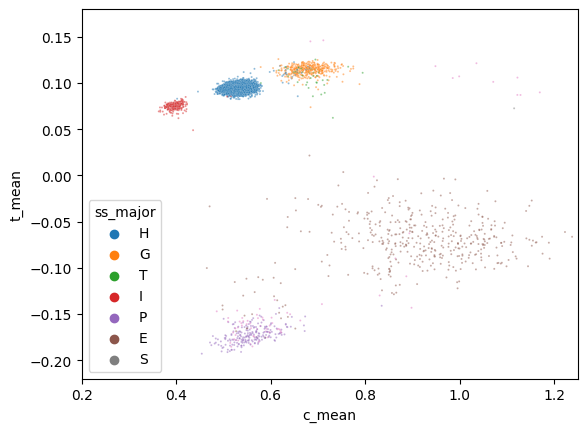

In [51]:
sns.scatterplot(data=grp_fdf_new, x="c_mean", y="t_mean", s=2, alpha=0.5,hue="ss_major")
plt.xlim(0.2,1.25)
plt.ylim(-0.22,0.18)
plt.savefig(save_dir+"ss_major_dist_kt_30.png", dpi=300)

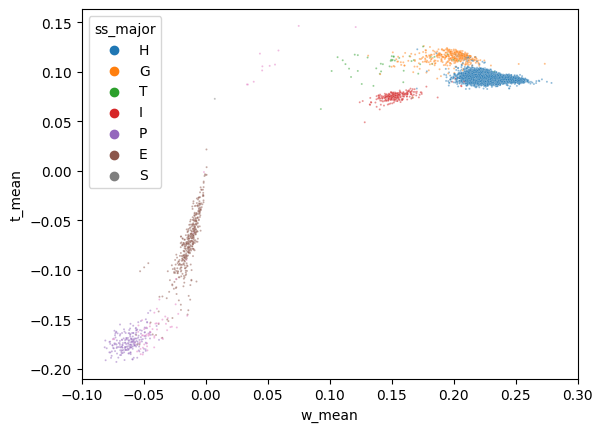

In [52]:
sns.scatterplot(data=grp_fdf_new, x="w_mean", y="t_mean", s=2, alpha=0.5,hue="ss_major")
plt.xlim(-0.1,0.3)
#plt.ylim(-0.5,0.4)
plt.savefig(save_dir+"ss_major_dist_wt_30.png", dpi=300)

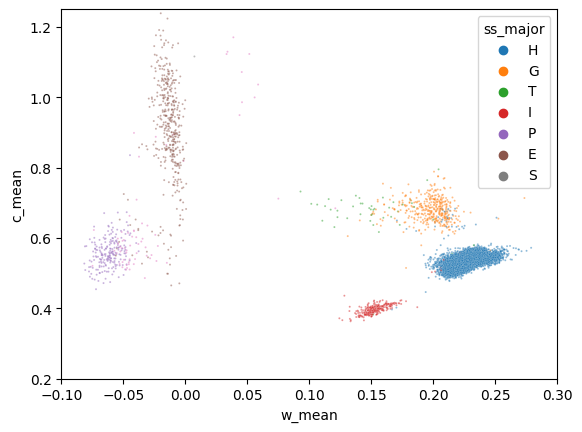

In [53]:
sns.scatterplot(data=grp_fdf_new, x="w_mean", y="c_mean", s=2, alpha=0.5,hue="ss_major")
plt.xlim(-0.1,0.3)
plt.ylim(0.2,1.25)
plt.savefig(save_dir+"ss_major_dist_wc_30.png", dpi=300)

# Clustering

We could just use the `SS_major` to identify the clusters, however, I want to see if we could recover the SS just based on the density of the regions geometrical helices occurs without having to rely too much on DSSP. We are not interested in handling beta-strands for now, so we gonna remove E and 

In [55]:
# remove E and S regions
non_E = grp_fdf_new["ss_major"] != "E"
#non_S = grp_fdf_new["ss_major"] != "S"

df_AP3P = grp_fdf_new.loc[non_E] #& non_S ]

In [56]:
print('|---------| Define Alpha/Pi/3(10)/PP2 canonical region |---------|')

# run hdbscan
min_cluster_size = 65 #25
# -----------------------------------------------------------------
# NOTE: using min_cluster_size = 25 you get an extra cluster which 
#       its meaning is not clear to me. It could be nothing, but 
#       it worths to check.
# ----------------------------------------------------------------
print('  > running hdbscan [min_cluster_size=',min_cluster_size,']...')

df_gh_clusters, clusterer = cluster_grp_frags(df_AP3P,
                                    cols = ['c_mean', 'w_mean', 't_mean'], method='hdbscan',
                                    min_cluster_size=min_cluster_size)


# Compute the membership vectors for the clustering assignment
print('  > computing membership vectors...')
soft_clusters = hdbscan.all_points_membership_vectors(clusterer)
df_gh_clusters['membership_vec'] = tuple(soft_clusters)
print("  > clusters found:")
print(df_gh_clusters["grp_frag_clusters"].unique())


|---------| Define Alpha/Pi/3(10)/PP2 canonical region |---------|
  > running hdbscan [min_cluster_size= 65 ]...
  > computing membership vectors...
  > clusters found:
[ 3  2  1  0 -1]


<AxesSubplot: xlabel='c_mean', ylabel='t_mean'>

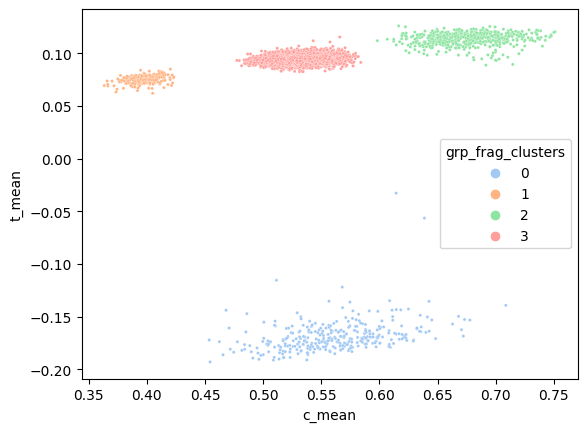

In [57]:
sns.scatterplot(data=df_gh_clusters.loc[~ (df_gh_clusters["grp_frag_clusters"] == -1)], x='c_mean', y='t_mean', hue='grp_frag_clusters', s=5, palette="pastel")#df_1_2


In [58]:
df_gh_clusters[df_gh_clusters["grp_frag_clusters"] == 0]

,res_start,res_final,kind,size,label,pdbid,chain,seq,c_mean,t_mean,...,hn2_A_mean,hn2_en_std,hn2_A_std,hn2_en_median,hn2_A_median,hn2_en_vals,hn2_A_vals,ss_major,grp_frag_clusters,membership_vec
1953,362,365,labels,4,PP2,2r7d,C,['D' 'P' 'L' 'S'],0.554100,-0.177700,...,-4.000000,0.057735,5.354126,-0.05,-4.5,[-0.1 -0. -0. -0.1],[ 2 -9 -8 -1],P,0,"[0.22969171338982478, 0.23534704569926276, 0.2..."
3851,62,65,labels,4,PP2,6a3w,L,['C' 'D' 'I' 'C'],0.597125,-0.178625,...,1.250000,0.050000,1.500000,-0.20,2.0,[-0.2 -0.2 -0.2 -0.1],[ 2 2 2 -1],None,0,"[0.16985268224846045, 0.1884467199470512, 0.22..."
4348,22,25,labels,4,PP2,3vxd,A,['R' 'L' 'L' 'T'],0.610250,-0.171775,...,70.250000,0.050000,135.856235,-0.10,4.0,[-0.1 -0.1 -0.1 -0.2],[ 3 274 -1 5],P,0,"[0.15437988820540224, 0.17318059408753106, 0.2..."
4623,129,133,labels,5,PP2,6nu9,A,['V' 'S' 'P' 'R' 'S'],0.563440,-0.173820,...,-43.400000,0.070711,40.500617,-0.10,-67.0,[-0.1 -0.1 -0.2 -0.1 -0. ],[-82 2 -67 -69 -1],,0,"[0.22760749312692663, 0.23420895971567643, 0.2..."
6435,313,316,labels,4,PP2,8znk,B,['E' 'A' 'D' 'R'],0.553475,-0.178925,...,-50.750000,0.050000,104.180532,-0.10,0.5,[-0.1 -0.2 -0.1 -0.1],[ 3 2 -1 -207],P,0,"[0.22694412930168492, 0.23510919918406006, 0.2..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
384839,318,321,labels,4,PP2,7ape,B,['R' 'Y' 'P' 'G'],0.564550,-0.164825,...,-41.750000,0.100000,84.187786,-0.10,-1.0,[-0.1 -0.1 -0.1 -0.3],[ 3 -1 -1 -168],P,0,"[0.2187687529244759, 0.22627136773542306, 0.25..."
386625,548,554,labels,7,PP2,3tiq,A,['G' 'P' 'V' 'K' 'G' 'D' 'S'],0.544857,-0.156214,...,-7.857143,0.111270,15.847487,-0.10,2.0,[-0.1 -0.4 -0.1 -0.2 -0.2 -0.1 -0.1],[-31 -31 2 2 2 2 -1],None,0,"[0.17290115662205996, 0.19401765375325858, 0.2..."
387750,251,254,labels,4,PP2,1pg4,B,['E' 'A' 'M' 'N'],0.635950,-0.159725,...,-112.750000,0.081650,102.213421,-0.20,-135.5,[-0.1 -0.2 -0.2 -0.3],[ -95 -176 -204 24],None,0,"[0.08818784248890152, 0.11272845965142105, 0.1..."
387929,197,202,labels,6,PP2,1dmh,A,['P' 'A' 'G' 'Y' 'G' 'C'],0.558483,-0.165300,...,-5.000000,0.150555,27.217641,-0.20,3.0,[-0.2 -0.2 -0.2 -0.4 -0. -0. ],[-37 -40 24 2 17 4],,0,"[0.22291057237446305, 0.23249877332551638, 0.2..."


In [60]:
# get core labels
Pc_LIM = 0.15
# 4.3) Determinate which points belongs to the core of the clusters
print(f'  > selecting data points belonging to clusters core (Pc_lim = {Pc_LIM})...')
df_gh_clusters['is_at_core'] = get_core_labels(df_gh_clusters, Pc_LIM=Pc_LIM)
print(df_gh_clusters[['membership_vec','is_at_core']])
core_df = df_gh_clusters.loc[df_gh_clusters['is_at_core']==True]
print(f"{len(core_df) =}")

  > selecting data points belonging to clusters core (Pc_lim = 0.15)...
                                           membership_vec  is_at_core
26      [0.07226384205998904, 0.10786034471198931, 0.1...       False
31      [0.12464532517072009, 0.18678309014297528, 0.2...        True
40      [0.10929431789190311, 0.16259787982256302, 0.1...        True
42      [0.1258819124556371, 0.1887749256140156, 0.210...        True
43      [0.02307342470386651, 0.03455545103810824, 0.0...       False
...                                                   ...         ...
390339  [0.12233717765699724, 0.18289146270743362, 0.2...        True
390341  [0.10910758865963863, 0.17155449938923564, 0.1...        True
390350  [0.028955047482906827, 0.04537441208668583, 0....       False
390351  [0.11554234602447594, 0.28021116044829686, 0.1...        True
390352  [0.02873266669852459, 0.06744419810709472, 0.0...       False

[86052 rows x 2 columns]
len(core_df) =57975


<AxesSubplot: xlabel='w_mean', ylabel='t_mean'>

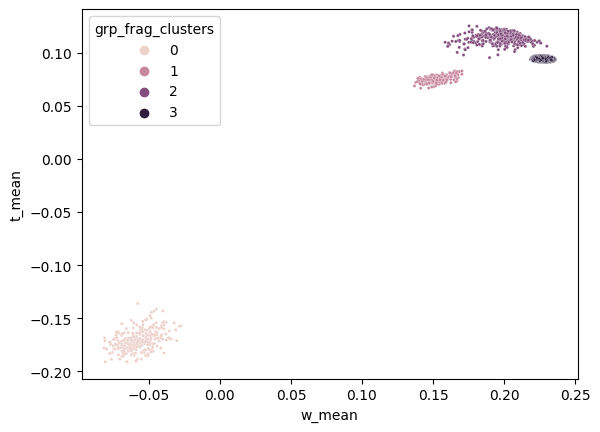

In [61]:
sns.scatterplot(data=core_df.loc[~ (core_df["grp_frag_clusters"] == -1)], x='w_mean', y='t_mean', hue='grp_frag_clusters', s=5)#df_1_2


<AxesSubplot: xlabel='c_mean', ylabel='t_mean'>

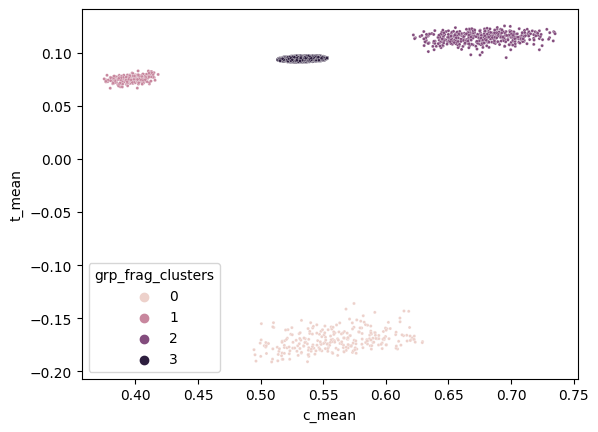

In [62]:
sns.scatterplot(data=core_df.loc[~ (core_df["grp_frag_clusters"] == -1)], x='c_mean', y='t_mean', hue='grp_frag_clusters', s=5)#df_1_2


Write canonical csvs

In [63]:
write_canonical_cluster_csvs(core_df)

@ 3
{'H': 57021}
@ 2
{'G': 350, 'H': 22, 'T': 9}
@ 1
{'I': 232, 'H': 2, 'T': 1}
@ 0
{'P': 186, '': 42}
{'H': 3, 'G': 2, 'I': 1, 'P': 0}


/tmp/ipykernel_4569/2966475518.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_c_slice_df.loc[:,"ssx_label"] = ssx_dssp_labels_dct[dssp_label]
/tmp/ipykernel_4569/2966475518.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_c_slice_df.loc[:,"ssx_label"] = ssx_dssp_labels_dct[dssp_label]
/tmp/ipykernel_4569/2966475518.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

In [67]:
!ls -lh

total 480M
-rw-rw-r-- 1 antonio antonio  82K Aug 31 01:12 '3(10)_can.csv'
-rw-rw-r-- 1 antonio antonio  82K Sep  7 02:19 '3(10)_can_1.csv'
-rw-rw-r-- 1 antonio antonio  67K Sep  9 23:37 '3(10)_can_2.csv'
-rw-rw-r-- 1 antonio antonio 239M Aug 31 01:12  Alpha_can.csv
-rw-rw-r-- 1 antonio antonio  45M Sep  7 19:44  Alpha_can_1.csv
-rw-rw-r-- 1 antonio antonio  99M Sep  7 02:19  Alpha_can_2.csv
-rw-rw-r-- 1 antonio antonio  84M Sep  9 23:37  Alpha_can_3.csv
-rw-rw-r-- 1 antonio antonio 6.3M Aug 31 02:03  PP2_can.csv
-rw-rw-r-- 1 antonio antonio 1.1M Sep  9 23:37  PP2_can_0.csv
-rw-rw-r-- 1 antonio antonio 928K Aug 31 01:12  Pi_can.csv
-rw-rw-r-- 1 antonio antonio 107K Sep  7 19:44  Pi_can_0.csv
-rw-rw-r-- 1 antonio antonio 347K Sep  9 23:37  Pi_can_1.csv
-rw-rw-r-- 1 antonio antonio 2.1M Sep  9 23:37  SetCanonicalRegions.ipynb
-rw-rw-r-- 1 antonio antonio 232K Aug 31 02:20  Turn_can_1.csv
-rw-rw-r-- 1 antonio antonio 914K Aug 31 02:03  UNDF_can.csv
-rw-rw-r-- 1 antonio antonio 914K Aug 31 

## Alpha/Pi/3(10) canonical regions

|---------| Alpha/Pi/3(10) canonical region |---------|
@ clustering |w| > 0.1...
   > filtering 
  :: 68290 frags after filtering


<AxesSubplot: xlabel='w_mean', ylabel='t_mean'>

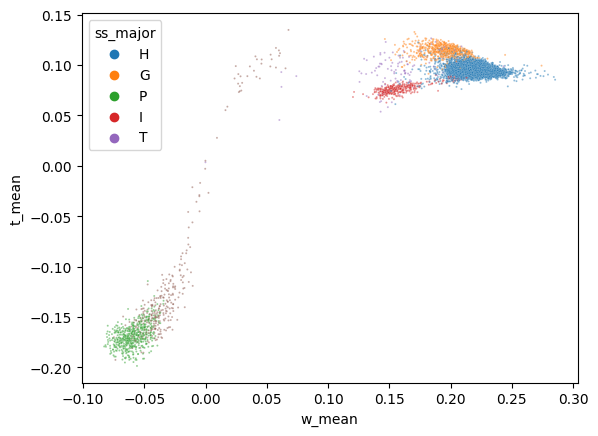

In [245]:

print('|---------| Alpha/Pi/3(10) canonical region |---------|')
# generate clusters for Pi, Alpha and 3(10)
#   Pi, Alpha and 3(10) helices residues belongs to the region of |w| > 0.1 and
# those  usually forms globular clusters. The strategy for those SSE is:
print('@ clustering |w| > 0.1...')
print('   > filtering ')
wgrtr_1 = grp_fdf_new['w_mean'] >  0.1

# remove E and S regions
non_E = grp_fdf_new["ss_major"] != "E"
non_S = grp_fdf_new["ss_major"] != "S"

ss_H = grp_fdf_new["ss_major"] == "H"
ss_I = grp_fdf_new["ss_major"] == "I"
ss_G = grp_fdf_new["ss_major"] == "G"

ss_T = grp_fdf_new["ss_major"] == "T"
ss_B = grp_fdf_new["ss_major"] == "B"
ss_P = grp_fdf_new["ss_major"] == "P"


df_AP3 = grp_fdf_new.loc[non_E & non_S ]#& wgrtr_1]# & (wgrtr_2)]

print(f'  :: {len(df_AP3)} frags after filtering')

sns.scatterplot(data=df_AP3, x="w_mean", y="t_mean", s=2, alpha=0.5,hue="ss_major")
#plt.ylim(0.05,0.15)

<AxesSubplot: xlabel='c_mean', ylabel='t_mean'>

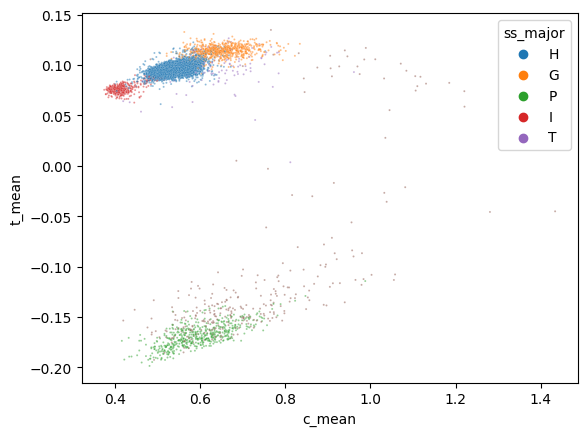

In [246]:
sns.scatterplot(data=df_AP3, x="c_mean", y="t_mean", s=2, alpha=0.5,hue="ss_major")
#plt.ylim(0.05,0.15)

In [247]:
# run hdbscan
min_cluster_size = 45 #25
# -----------------------------------------------------------------
# NOTE: using min_cluster_size = 25 you get an extra cluster which 
#       its meaning is not clear to me. It could be nothing, but 
#       it worths to check.
# ----------------------------------------------------------------
print('  > running hdbscan [min_cluster_size=',min_cluster_size,']...')

df_1_2_alpha, clusterer = cluster_grp_frags(df_AP3,
                                    cols = ['c_mean', 'w_mean', 't_mean'], method='hdbscan',
                                    min_cluster_size=min_cluster_size)


# Compute the membership vectors for the clustering assignment
print('  > computing membership vectors...')
soft_clusters = hdbscan.all_points_membership_vectors(clusterer)
df_1_2_alpha['membership_vec'] = tuple(soft_clusters)
print("  > clusters found:")
print(df_1_2_alpha["grp_frag_clusters"].unique())


  > running hdbscan [min_cluster_size= 45 ]...
  > computing membership vectors...
  > clusters found:
[ 3 -1  0  1  2]


<AxesSubplot: xlabel='c_mean', ylabel='t_mean'>

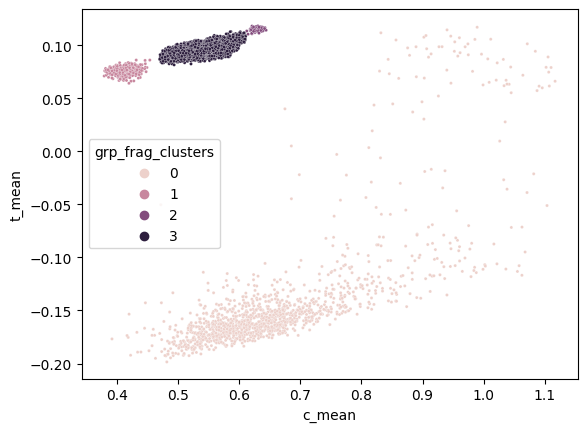

In [248]:
sns.scatterplot(data=df_1_2_alpha.loc[~ (df_1_2_alpha["grp_frag_clusters"] == -1)], x='c_mean', y='t_mean', hue='grp_frag_clusters', s=5)#df_1_2
#sns.scatterplot(data=df_1_2.loc[(df_1_2["grp_frag_clusters"] == -1)], x='c_mean', y='t_mean', hue='grp_frag_clusters', s=.5)#df_1_2


<AxesSubplot: xlabel='c_mean', ylabel='t_mean'>

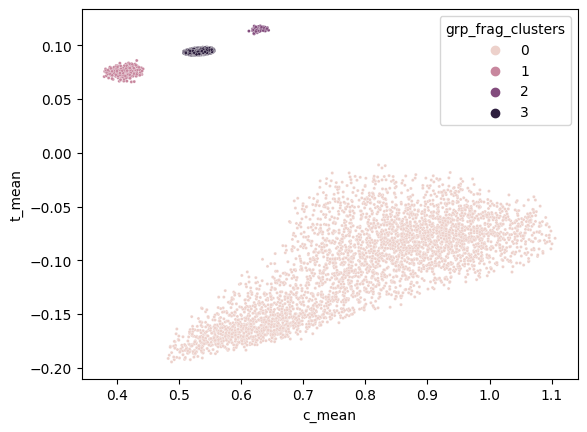

In [23]:
sns.scatterplot(data=core_df.loc[~ (core_df["grp_frag_clusters"] == -1)], x='c_mean', y='t_mean', hue='grp_frag_clusters', s=5)

In [24]:
sns.scatterplot(data=df_1_2_alpha.loc[~ (df_1_2_alpha["grp_frag_clusters"] == -1)], x='w_mean', y='t_mean', hue='grp_frag_clusters', s=5)#df_1_2


NameError: name 'df_1_2_alpha' is not defined

In [25]:
# get core labels
Pc_LIM = 0.15
# 4.3) Determinate which points belongs to the core of the clusters
print(f'  > selecting data points belonging to clusters core (Pc_lim = {Pc_LIM})...')
df_1_2_alpha['is_at_core'] = get_core_labels(df_1_2_alpha, Pc_LIM=Pc_LIM)
print(df_1_2_alpha[['membership_vec','is_at_core']])
core_df = df_1_2_alpha.loc[df_1_2_alpha['is_at_core']==True]
print(f"{len(core_df) =}")

  > selecting data points belonging to clusters core (Pc_lim = 0.15)...


NameError: name 'df_1_2_alpha' is not defined

<AxesSubplot: xlabel='c_mean', ylabel='t_mean'>

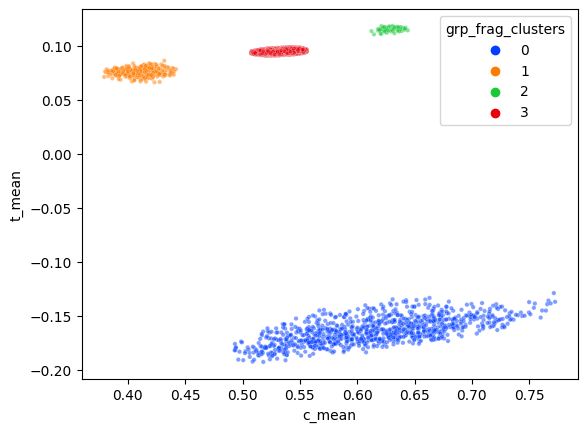

In [253]:
#sns.scatterplot(data=df_1_2, x="c_mean", y="t_mean", s=2, alpha=0.5,label="df_1_2", c="grey")
sns.scatterplot(data=core_df.loc[~ (core_df["grp_frag_clusters"] == -1)], x="c_mean", y="t_mean", s=10, alpha=0.5,hue="grp_frag_clusters", palette="bright")

<AxesSubplot: xlabel='w_mean', ylabel='t_mean'>

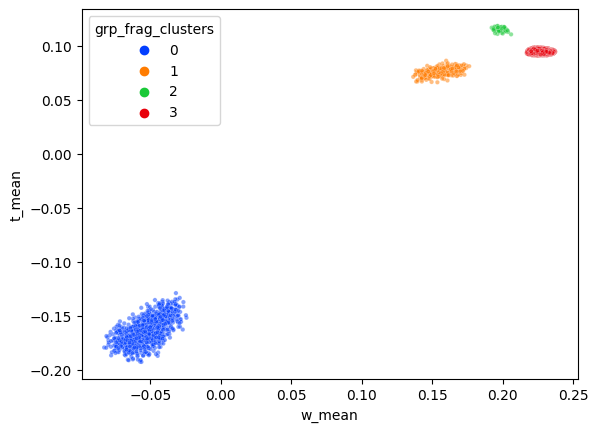

In [254]:
sns.scatterplot(data=core_df.loc[~ (core_df["grp_frag_clusters"] == -1)], x="w_mean", y="t_mean", s=10, alpha=0.5,hue="grp_frag_clusters", palette="bright")

## Write canonical csvs
We may consider to use the same DSSP labels for SSAxgeo, for now I will keep the old behaviour just to keep it compatible with other scripts.



In [255]:
write_canonical_cluster_csvs(core_df) #df_1_2_alpha)

@ 3
{'H': 45536}


/tmp/ipykernel_216281/1552295541.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_c_slice_df.loc[:,"ssx_label"] = ssx_dssp_labels_dct[dssp_label]


@ -1
@ 0
{'P': 487, '': 144}


/tmp/ipykernel_216281/1552295541.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_c_slice_df.loc[:,"ssx_label"] = ssx_dssp_labels_dct[dssp_label]


@ 1
{'I': 287, 'H': 6, 'T': 2}


/tmp/ipykernel_216281/1552295541.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_c_slice_df.loc[:,"ssx_label"] = ssx_dssp_labels_dct[dssp_label]


@ 2
{'G': 48, 'H': 2, 'T': 1}
{'H': 3, 'P': 0, 'I': 1, 'G': 2}


/tmp/ipykernel_216281/1552295541.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_c_slice_df.loc[:,"ssx_label"] = ssx_dssp_labels_dct[dssp_label]


@ -1
@ 1
{'G': 46, 'T': 1}
@ 0
{'I': 714, 'H': 23, 'T': 9}


/tmp/ipykernel_62360/717756374.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_c_slice_df.loc[:,"ssx_label"] = ssx_dssp_labels_dct[dssp_label]
/tmp/ipykernel_62360/717756374.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_c_slice_df.loc[:,"ssx_label"] = ssx_dssp_labels_dct[dssp_label]


{'H': 2, 'G': 1, 'I': 0}


### Check helices on the clusters

In [158]:
cols = ["pdbid","chain","res_start","res_final","size","ss", "ss_major"]
#df_1_2_alpha.loc[df_1_2_alpha["grp_frag_clusters"] == 0][cols]
core_df.loc[core_df["grp_frag_clusters"] == 0][cols]

,pdbid,chain,res_start,res_final,size,ss,ss_major
1426,8ec3,A,284,288,5,"[I, I, I, I, I]",I
9403,1lqv,B,165,168,4,"[I, I, I, I]",I
10143,1xfi,A,226,230,5,"[I, I, I, I, I]",I
19261,4mes,A,84,87,4,"[I, I, I, I]",I
21309,6dte,B,236,243,8,"[I, I, I, I, I, I, I, I]",I
29845,6cgm,A,38,41,4,"[I, I, I, I]",I
32471,4l6g,B,239,242,4,"[I, I, I, I]",I
36722,5aed,A,391,395,5,"[I, I, I, I, I]",I
44042,2pnk,D,81,84,4,"[I, I, I, I]",I
46673,7di7,A,693,696,4,"[I, I, I, I]",I


In [159]:
#df_1_2_alpha.loc[df_1_2_alpha["grp_frag_clusters"] == 1][cols]
core_df.loc[core_df["grp_frag_clusters"] == 1][cols]

,pdbid,chain,res_start,res_final,size,ss,ss_major
39,2cwd,B,18,30,13,"[H, H, H, H, H, H, H, H, H, H, H, H, H]",H
40,2cwd,B,58,63,6,"[H, H, H, H, H, H]",H
54,1zav,A,6,19,14,"[H, H, H, H, H, H, H, H, H, H, H, H, H, T]",H
58,1zav,A,94,104,11,"[H, H, H, H, H, H, H, H, H, H, H]",H
106,7wme,A,90,98,9,"[H, H, H, H, H, H, H, H, H]",H
...,...,...,...,...,...,...,...
347929,7vmb,B,132,159,28,"[H, H, H, H, H, H, H, H, H, H, H, H, H, H, H, ...",H
347946,7vnx,A,11,20,10,"[H, H, H, H, H, H, H, H, H, H]",H
347947,7vnx,A,61,73,13,"[H, H, H, H, H, H, H, H, H, H, H, H, H]",H
347948,7vnx,A,112,124,13,"[H, H, H, H, H, H, H, H, H, H, H, H, H]",H


In [160]:
core_df.loc[core_df["grp_frag_clusters"] == 2][cols]

,pdbid,chain,res_start,res_final,size,ss,ss_major
2333,2ibt,D,318,321,4,"[G, G, G, G]",G
8822,1dm1,A,38,42,5,"[G, G, G, G, G]",G
10622,2c5q,E,227,231,5,"[H, G, G, G, G]",G
17773,3nft,A,1168,1171,4,"[G, G, G, G]",G
21008,4eoi,D,318,321,4,"[H, H, T, T]",None
30163,4hb2,C,47,51,5,"[G, G, G, G, H]",G
30464,1w07,B,276,279,4,"[T, T, H, H]",None
32068,2omz,A,334,337,4,"[G, G, G, G]",G
11973,5enp,B,123,128,6,"[G, G, G, G, G, G]",G
40356,3ss9,X,249,252,4,"[H, T, H, H]",None


## PP2 helix

|---------| PP2 canonical region |---------|
@ clustering |w|  0.1...
   > filtering 
  :: 1029 frags after filtering


<AxesSubplot: xlabel='c_mean', ylabel='t_mean'>

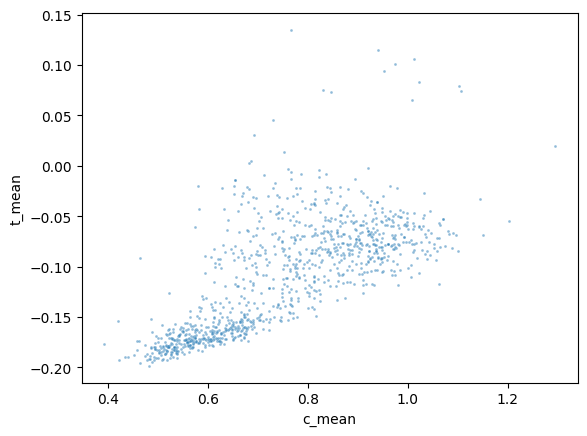

In [60]:
print('|---------| PP2 canonical region |---------|')
# generate clusters for PP2
print('@ clustering |w|  0.1...')
print('   > filtering ')

# remove E and S regions
non_E = grp_fdf_new["ss_major"] != "E"
non_S = grp_fdf_new["ss_major"] != "S"

non_NONE = grp_fdf_new["ss_major"] != ""

ss_H = grp_fdf_new["ss_major"] == "H"
ss_I = grp_fdf_new["ss_major"] == "I"
ss_G = grp_fdf_new["ss_major"] == "G"

ss_T = grp_fdf_new["ss_major"] == "T"
ss_B = grp_fdf_new["ss_major"] == "B"
ss_P = grp_fdf_new["ss_major"] == "P"

wgrtr_2 = grp_fdf_new['w_mean'] <  0.1


#filter std
c_std_cond = grp_fdf_new['c_std'] <= 0.35 #0.55
t_std_cond = grp_fdf_new['t_std'] <= 0.015

df_prov = grp_fdf_new.loc[ wgrtr_2 ]# non_E & non_S  & (wgrtr_2)]

print(f'  :: {len(df_prov)} frags after filtering')

sns.scatterplot(data=df_prov, x="c_mean", y="t_mean", alpha=0.5, s=4)#,hue="ss_major")
#plt.ylim(0.05,0.15)

<AxesSubplot: xlabel='w_mean', ylabel='t_mean'>

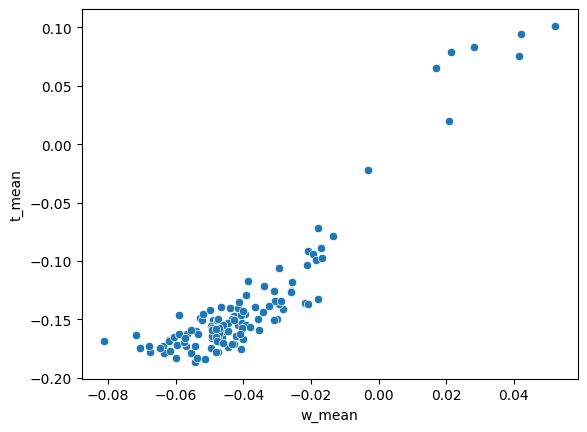

In [61]:
#sns.scatterplot(data=df_prov, x="w_mean", y="t_mean", alpha=0.5)#,hue="ss_major")
#df_prov["ss_major"] = df_prov.loc[df_prov["ss_major"].isna()]["ss"].apply(count_occurrences_above_threshold, threshold_percentage=51)#[["size","ss","ss_major"]]
#sns.scatterplot(data=df_prov, x="w_mean", y="t_mean", alpha=0.5,hue="ss_major")
sns.scatterplot(data=df_prov.loc[df_prov["ss_major"].isna()], x="w_mean", y="t_mean")

  > running hdbscan [min_cluster_size= 15 ]...
  > computing membership vectors...
  > clusters found:
[ 0 -1]


Index(['res_start', 'res_final', 'kind', 'size', 'label', 'pdbid', 'chain',
       'seq', 'c_mean', 't_mean', 'w_mean', 'c_std', 't_std', 'w_std', 'c_raw',
       't_raw', 'w_raw', 'cs_raw', 'ts_raw', 'ws_raw', 'cs_mean', 'ts_mean',
       'ws_mean', 'c_std_s', 't_std_s', 'ws_std', 'phi', 'psi', 'ss', 'ss_pp2',
       'ho1_en_mean', 'ho1_A_mean', 'ho1_en_std', 'ho1_A_std', 'ho1_en_median',
       'ho1_A_median', 'ho1_en_vals', 'ho1_A_vals', 'ho2_en_mean',
       'ho2_A_mean', 'ho2_en_std', 'ho2_A_std', 'ho2_en_median', 'ho2_en_vals',
       'ho2_A_vals', 'hn1_en_mean', 'hn1_A_mean', 'hn1_en_std', 'hn1_A_std',
       'hn1_en_median', 'hn1_A_median', 'hn1_en_vals', 'hn1_A_vals',
       'hn2_en_mean', 'hn2_A_mean', 'hn2_en_std', 'hn2_A_std', 'hn2_en_median',
       'hn2_A_median', 'hn2_en_vals', 'hn2_A_vals', 'ss_major',
       'grp_frag_clusters'],
      dtype='object')

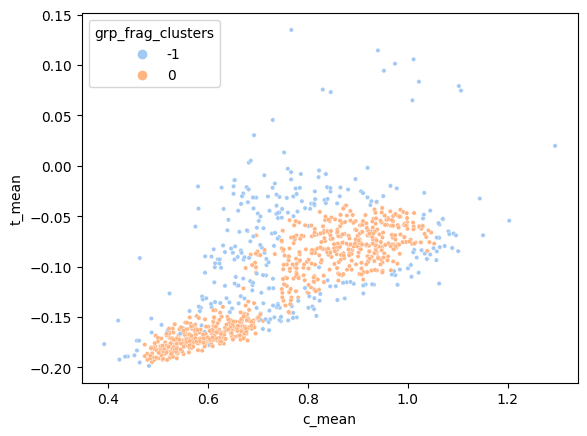

In [76]:
min_cluster_size = 15 #25
# -----------------------------------------------------------------
# NOTE: using min_cluster_size = 25 you get an extra cluster which 
#       its meaning is not clear to me. It could be nothing, but 
#       it worths to check.
# ----------------------------------------------------------------
print('  > running hdbscan [min_cluster_size=',min_cluster_size,']...')

df_1_2_pp2, clusterer_pp2 = cluster_grp_frags(df_prov,
                                    cols = ['c_mean', 'w_mean', 't_mean'], method='hdbscan',
                                    min_cluster_size=min_cluster_size)


# Compute the membership vectors for the clustering assignment
print('  > computing membership vectors...')
#soft_clusters_pp2 = hdbscan.all_points_membership_vectors(clusterer_pp2)
#df_1_2_pp2['membership_vec'] = tuple(soft_clusters_pp2)
print("  > clusters found:")
print(df_1_2_pp2["grp_frag_clusters"].unique())
sns.scatterplot(data=df_1_2_pp2, x="c_mean", y="t_mean", s=10, alpha=1.0, hue="grp_frag_clusters", palette="pastel")
df_1_2_pp2.columns

In [168]:
# get core labels
Pc_LIM = 0.35
# 4.3) Determinate which points belongs to the core of the clusters
print(f'  > selecting data points belonging to clusters core (Pc_lim = {Pc_LIM})...')
df_1_2_pp2['is_at_core'] = get_core_labels(df_1_2_pp2, Pc_LIM=Pc_LIM)
print(df_1_2_pp2[['membership_vec','is_at_core']])
core_df_pp2 = df_1_2_pp2.loc[df_1_2_pp2['is_at_core']==True]
print(f"{len(df_prov) =}")
print(f"{len(core_df_pp2) =}")

  > selecting data points belonging to clusters core (Pc_lim = 0.35)...
                                    membership_vec  is_at_core
543     [0.39628356552788224, 0.44965189901842306]        True
581       [0.3714899836212058, 0.3907171781142023]        True
609      [0.2876869316053129, 0.29620316105263456]       False
705       [0.5587761847195105, 0.4118434620107047]        True
777      [0.37490038775019535, 0.4196960578341646]        True
...                                            ...         ...
346936   [0.3142081466756897, 0.31945233728137484]       False
347056   [0.3425047293837539, 0.37488853028494934]        True
347061     [0.5401511960153947, 0.422347439541168]        True
347635    [0.6059110441071502, 0.3940889558928499]        True
347926   [0.1378758464688001, 0.25234281250224916]       False

[3424 rows x 2 columns]
len(df_prov) =3424
len(core_df_pp2) =1861


,res_start,res_final,kind,size,label,pdbid,chain,seq,c_mean,t_mean,...,hn2_en_std,hn2_A_std,hn2_en_median,hn2_A_median,hn2_en_vals,hn2_A_vals,ss_major,grp_frag_clusters,membership_vec,is_at_core
543,65,69,not_round,5,1.0,8a14,A,"[P, P, A, K, D]",0.610660,-0.159040,...,0.151658,19.841875,-0.1,2.0,"[-0.1, 0.0, -0.1, -0.4, -0.2]","[-1, 0, 36, 2, 37]",P,1,"[0.39628356552788224, 0.44965189901842306]",True
581,163,171,not_round,9,3.0,8a4o,D,"[R, A, L, V, K, V, P, Q, T]",0.776244,-0.118856,...,0.190029,23.514771,-0.2,3.0,"[-0.6, -0.4, -0.4, -0.5, -0.2, -0.1, -0.1, -0....","[74, 2, 2, 2, 11, 3, 2, 5, 5]",NaN,1,"[0.3714899836212058, 0.3907171781142023]",True
777,214,218,not_round,5,3.0,8b28,A,"[P, L, D, P, P]",0.667920,-0.171580,...,0.054772,9.289779,-0.1,-5.0,"[-0.1, -0.0, -0.1, -0.1, -0.0]","[-5, -7, -1, 2, -22]",P,1,"[0.37490038775019535, 0.4196960578341646]",True
1197,256,259,not_round,4,1.0,8dc1,A,"[W, Y, T, S]",0.766750,-0.135875,...,0.2,35.141381,-0.1,3.5,"[-0.1, -0.5, -0.1, -0.1]","[13, 2, 5, -63]",None,1,"[0.38999256548426314, 0.4019426868282308]",True
1223,39,45,not_round,7,1.0,6lgd,A,"[P, T, E, V, I, Q, L]",0.626571,-0.166543,...,0.053452,237.34905,-0.1,3.0,"[-0.1, 0.0, -0.1, -0.0, 0.0, -0.1, -0.1]","[502, 0, -1, 473, 0, 3, 5]",P,1,"[0.4453810572881473, 0.5091155146174363]",True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345899,148,151,not_round,4,1.0,7oa8,A,"[I, V, P, V]",0.682125,-0.142925,...,0.05,73.03595,-0.1,77.0,"[-0.1, -0.2, -0.1, -0.1]","[141, 14, 14, 140]",NaN,1,"[0.40813094969480335, 0.44067421601063517]",True
346240,100,109,not_round,10,1.0,7pok,C,"[P, S, P, L, E, K, P, R, A, P]",0.600220,-0.160860,...,0.063246,15.506271,-0.1,-11.0,"[-0.1, 0.0, -0.2, -0.0, -0.0, -0.1, -0.1, -0.1...","[-1, 0, -1, -21, -1, -26, -1, -29, -36, -34]",P,1,"[0.39033113564331234, 0.4263590633166755]",True
346532,31,37,not_round,7,1.0,7qrr,D,"[T, T, I, A, L, D, P]",0.695729,-0.149886,...,0.121499,10.123052,-0.2,2.0,"[-0.3, -0.3, -0.3, -0.0, -0.1, -0.1, -0.2]","[2, -12, 2, -1, 3, 22, -1]",NaN,1,"[0.40914615750556316, 0.46243014864515997]",True
346627,510,513,not_round,4,1.0,7qzq,A,"[V, R, K, C]",0.657700,-0.150250,...,0.05,6.946222,-0.2,-5.0,"[-0.1, -0.2, -0.2, -0.2]","[-1, -9, 2, -13]",None,1,"[0.38248986258348283, 0.4400400882570974]",True


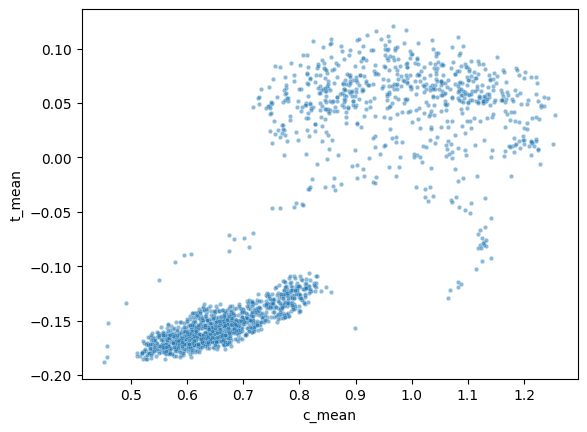

In [172]:
#sns.scatterplot(data=df_1_2_pp2.loc[~ (df_1_2_pp2["grp_frag_clusters"] == -1)], x='c_mean', y='t_mean', hue='grp_frag_clusters', s=5)#df_1_2
#sns.scatterplot(data=core_df_pp2.loc[~ (core_df_pp2["grp_frag_clusters"] == -1)], x="c_mean", y="t_mean", s=5, alpha=0.5,hue="grp_frag_clusters", palette="bright")
sns.scatterplot(data=core_df_pp2, x="c_mean", y="t_mean", s=10, alpha=0.5)
core_df_pp2[core_df_pp2["grp_frag_clusters"] == 1]

<AxesSubplot: xlabel='w_mean', ylabel='t_mean'>

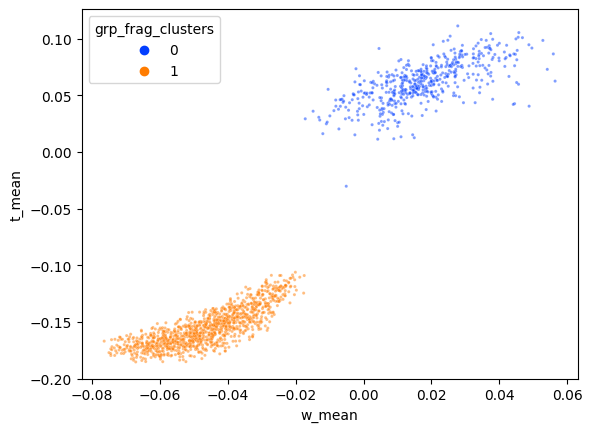

In [173]:
sns.scatterplot(data=core_df_pp2.loc[~ (core_df_pp2["grp_frag_clusters"] == -1)], x="w_mean", y="t_mean", s=5, alpha=0.5,hue="grp_frag_clusters", palette="bright")


In [180]:
pd.set_option('display.max_rows', 100)
core_df_pp2[core_df_pp2["grp_frag_clusters"] == 0]["ss_major"].value_counts()

     40
S     5
T     1
E     1
Name: ss_major, dtype: int64

In [181]:
core_df_pp2[(core_df_pp2["grp_frag_clusters"] == 0) & (core_df_pp2["size"] > 5)][["res_start", "res_final", "size", "pdbid","chain","ss", "ss_major"]]

,res_start,res_final,size,pdbid,chain,ss,ss_major
20373,52,57,6,7z15,G,"[H, S, , , , H]",None
44200,570,575,6,2qub,E,"[, , , S, , G]",NaN
105908,154,159,6,1h80,B,"[, , , , B, E]",NaN
116014,42,47,6,4qgp,B,"[T, T, , , S, H]",None
117268,259,264,6,5qec,A,"[T, , S, , S, H]",None
181550,47,52,6,4nb5,A,"[H, , S, S, S, ]",None
267297,222,229,8,6c7n,D,"[S, S, , S, , , , E]",None
276291,159,164,6,4m3p,D,"[E, E, E, S, , H]",None
292274,14,19,6,2plx,B,"[S, , , , , H]",NaN
330724,93,98,6,6bea,A,"[E, E, E, , , S]",None


<AxesSubplot: xlabel='c_mean', ylabel='t_mean'>

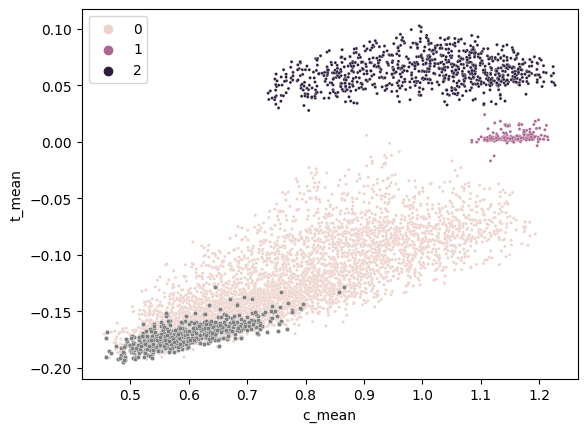

In [50]:
#sns.scatterplot(data=df_1_2_pp2.loc[~ (df_1_2_pp2["grp_frag_clusters"] == -1)], x='c_mean', y='t_mean', hue='grp_frag_clusters', s=5)#df_1_2
#sns.scatterplot(data=df_1_2_pp2.loc[~ (df_1_2_pp2["grp_frag_clusters"] == -1) & (df_1_2_pp2["ss_major"] == "P")], x='c_mean', y='t_mean', s=10, c="grey")#df_1_2


<AxesSubplot: xlabel='w_mean', ylabel='t_mean'>

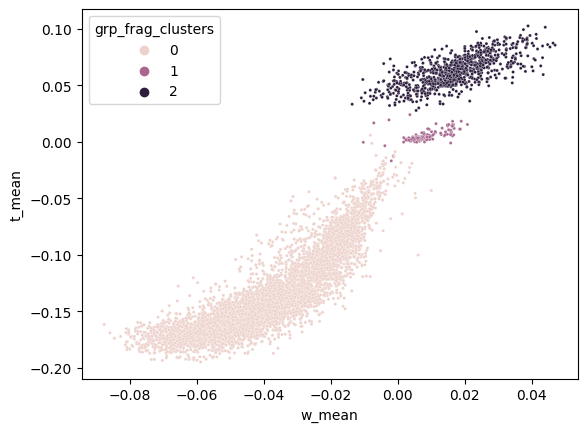

In [51]:
sns.scatterplot(data=df_1_2_pp2.loc[~(df_1_2_pp2["grp_frag_clusters"] == -1)], x='w_mean', y='t_mean', hue='grp_frag_clusters', s=5)#df_1_2


### What is the second cluster? [STASZEK]

Our initial approach was to just consider PP2 helices, which works fine. But with this new way to cluster, we are able to identify a second cluster which does not have an DSSP which dominates the set. In terms of density, it seems to be a pretty solid cluster. However, I didn't had much time to check the structures and see what this region means. If it actually means something, is not obvious to my eyes. I have a theory, but would like to see if you could catch something I am not.

# Write pp2 canonical csvs

In [59]:
write_canonical_cluster_csvs(df_1_2_pp2)

@ 0
{'P': 590, '': 501, 'B': 5, 'T': 1}


/tmp/ipykernel_62360/1552295541.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_c_slice_df.loc[:,"ssx_label"] = ssx_dssp_labels_dct[dssp_label]


@ 2
{'': 15, 'H': 3, 'T': 2}


/tmp/ipykernel_62360/1552295541.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_c_slice_df.loc[:,"ssx_label"] = ssx_dssp_labels_dct[dssp_label]


@ -1
@ 1
{'T': 1}
{'P': 0, '': 2, 'T': 1}


/tmp/ipykernel_62360/1552295541.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_c_slice_df.loc[:,"ssx_label"] = ssx_dssp_labels_dct[dssp_label]


In [ ]:
# TODO MIGRATE CODE TO DIFFGEO OR FLEXGEO